# BetterReads: Optimizing the k-means clustering model

This notebook explores how to optimize the k-means clustering model that underlies the BetterReads algorithm. We assume the general model framework laid out in the `01_modelling_with_use.ipynb` notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import tensorflow_hub as hub

plt.rcParams['figure.figsize']=(8.0, 6.0)
%config InlineBackend.figure_format='retina'

In [2]:
# Loads Universal Sentence Encoder locally, from downloaded module
embed = hub.load('../../Universal Sentence Encoder/module/')

# Loads Universal Sentence Encoder remotely, from Tensorflow Hub
# embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

## The goal

Recall that the goal of the BetterReads algorithm is to generate a list of the most commonly expressed opinions across all of a book's reviews. Ultimately, we will want to optimize our model in such a way that meaningful results can be obtained no matter the book we give it. We will begin, however, by working on just one book. After arriving at some preliminary results with this first book, we will move on to analyze other books, to determine how these preliminary results can be generalized.

Given that we are working with a k-means clustering model, the main parameter we have to optimize is k: the number of clusters to identify (or, in our case, the number of opinions). As is typical with k-means clustering optimization, we do not know in advance the actual number of clusters in our dataset. At this stage, we have to optimize our k parameter through trial and error.

However, there are other ways in which our case is unlike typical k-means clustering optimization. First off, **we are not attempting to classify *all* of the points in the dataset as belonging to one or another cluster.** Remember, we are clustering our data in order to identify the cluster *centres*, and then find the individual sentences that are *closest* to these centres. As such, **it is not so relevant if there are many outliers at the peripheries of our clusters, so long as each cluster centre is appropriately dense.**

Secondly, our choice of k is not unbounded. Remember that our goal is to generate a concise list of the most commonly expressed opinions across a book's reviews, so as to give users a quick sense of what people are saying about the book. Choosing a k value of 50, and thus generating a list of 50 distinct opinions, would be at odds with this goal. With this in mind, **we will constain our value of k to be no higher than 10.**

## Exploratory optimization: *Gone Girl*

Let us begin with *Gone Girl*, the book we worked with in the last notebook. There are two common ways to find the optimal value of k: via the model's inertia score or via its silhouette score. Here we calculate these two scores for k values between 2 and 10.

In [3]:
def load_sentences(file_path):
    '''
    Function to load and embed a book's sentences
    '''
    
    # Read in processed file as dataframe
    df = pd.read_csv(file_path)

    # Copy sentence column to new variable
    sentences = df['sentence'].copy()

    # Vectorize sentences
    sentence_vectors = embed(sentences)
    
    return sentences, sentence_vectors

In [4]:
def get_scores(sentence_vectors, k_min=2, k_max=10):
    '''
    Function to calculate a k-means model's inertia and silhouette scores for a range of k values
    '''

    # Set range of k values to loop through
    ks = range(k_min, k_max + 1)

    # Initialize lists to store inertia scores and silhouette scores
    inertia_scores = []
    sil_scores = []

    # Loop through values of k
    for k in ks:

        # Instantiate the model
        kmeans_model = KMeans(n_clusters=k, random_state=24)

        # Fit the model
        kmeans_model.fit(sentence_vectors)

        # Append the model's inertia score to master list
        inertia_scores.append(kmeans_model.inertia_)

        # Append the model's silhouette score to master list
        labels = kmeans_model.labels_
        sil_score = silhouette_score(sentence_vectors, labels)
        sil_scores.append(sil_score)
        
    return inertia_scores, sil_scores, ks

In [5]:
# Load and embed sentences
gg_sentences, gg_sentence_vectors = load_sentences('data/8442457_gone_girl.csv')

In [6]:
# Calculate inertia and silhouette scores
inertia_scores, sil_scores, ks = get_scores(gg_sentence_vectors)

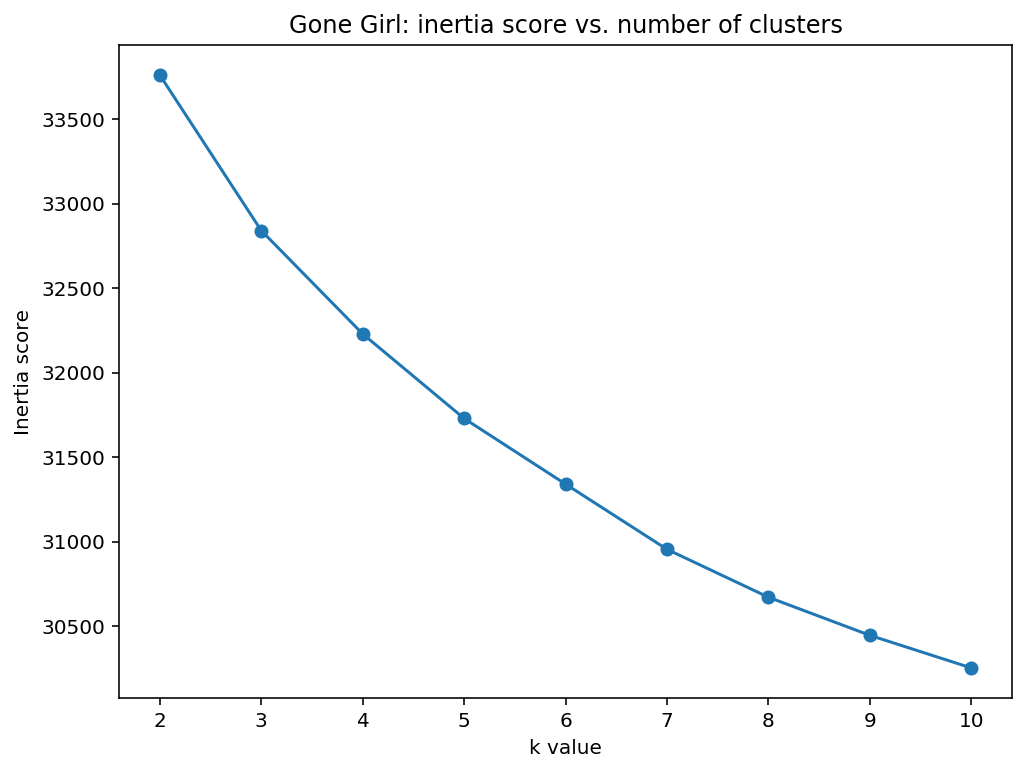

In [7]:
plt.figure()
plt.plot(ks, inertia_scores, marker='o')
plt.xlabel('k value')
plt.ylabel('Inertia score')
plt.title('Gone Girl: inertia score vs. number of clusters')
plt.show()

An inertia score plot like this is used to identify the optimal value of k via the so-called "elbow method". What we are looking for is a point in the plot where there is a sharp bend, like an elbow, before which the inertia score is dropping sharply and after which it is decreasing only slightly. This plot has no clear elbow (at least within the range that we've limited ourselves to), and thus does not help us identify the optimal value for k.

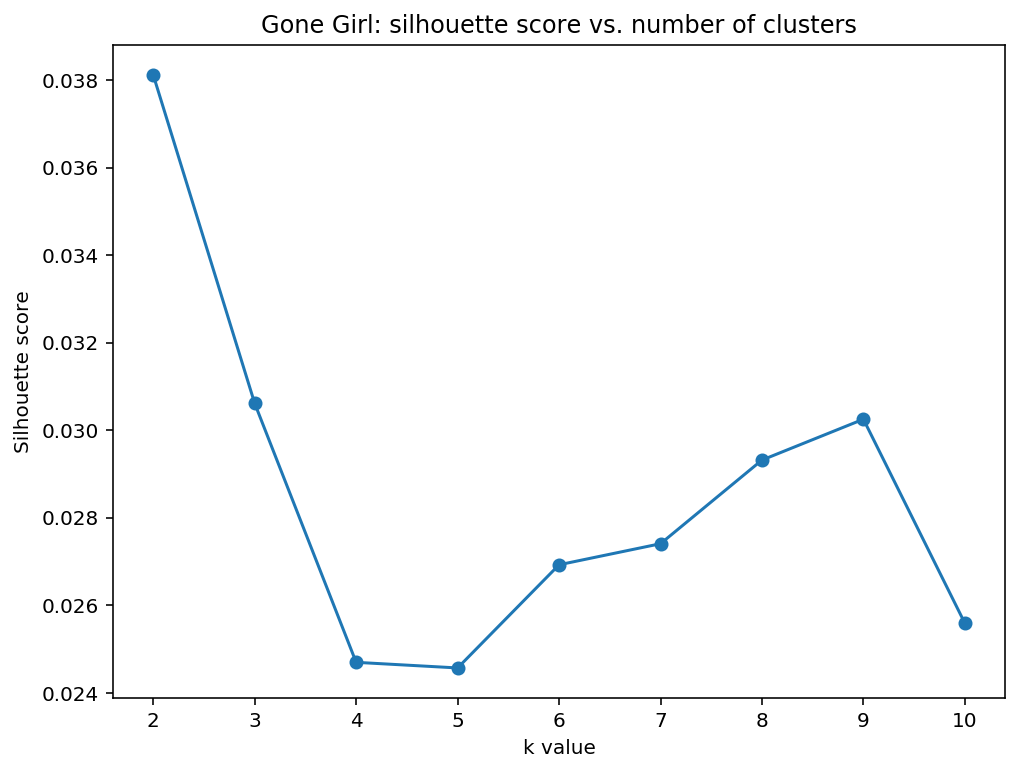

In [8]:
plt.figure()
plt.plot(ks, sil_scores, marker='o')
plt.xlabel('k value')
plt.ylabel('Silhouette score')
plt.title('Gone Girl: silhouette score vs. number of clusters')
plt.show()

A silhouette score plot like this uses a different method to identify the optimal value of k. Here we are now looking for a "peak" in our data – not necessarily the highest score in our data, but rather a point at which the scores stop increasing and start decreasing. This plot has a clear peak, at k = 9. So perhaps 9 is the optimal value of k. Let's see what the sentences at the centre of these clusters look like.

In [9]:
def get_clusters(sentences, sentence_vectors, k, n):
    '''
    Function to extract the n most representative sentences from k clusters
    '''

    # Instantiate the model
    kmeans_model = KMeans(n_clusters=k, random_state=24)

    # Fit the model
    kmeans_model.fit(sentence_vectors);
    
    # Loop through number of clusters
    for i in range(k):

        # Define cluster centre
        centre = kmeans_model.cluster_centers_[i]

        # Calculate inner product of cluster centre and sentence vectors
        ips = np.inner(centre, sentence_vectors)

        # Find the sentences with the highest inner products
        top_indices = pd.Series(ips).nlargest(n).index
        top_sentences = list(sentences[top_indices])

        print(f'Cluster #{i+1} sentences:\n')
        print(*top_sentences, sep='\n')
        print('\n')

In [10]:
get_clusters(gg_sentences, gg_sentence_vectors, k=9, n=8)

Cluster #1 sentences:

It was a very quick read and I enjoyed the twists in the plot.
The book has an intriguing premise, and shocking twists, but I wanted a more satisfying ending.
The plot has so many twists and turns in it that I felt it was a little hard to keep up and defantly hard to figure out the ending, which I do in a murder mystery novel.
The suspense was great and the plot twists were very interesting, however, it just ended.
I loved the plot twists and the unexpected turns in this tale.
I guess that's what thrillers are supposed to do, but I enjoyed the twists and plot surprises before it became anti-climactic.
It is an amazing psychological thriller, very well written and full of plot twists and turns.
The writing was excellent, the plot twists were surprising, it was suspenseful and i couldn't put it down.


Cluster #2 sentences:

It was so disturbingly messed up in a wonderful "I need to keep reading" type of way!
I'm pretty sure I hate it, but it might just be brillian

These results look pretty good! Each cluster displays a high degree of semantic similarity across its sentences, and each cluster is suitably different from the other clusters. (The only possible exceptions are clusters #3 and #4, which both concern the book's ending. However, these clusters do actually seem to represent different attitudes towards the ending: cluster #1's sentences loved the book despite the ending, whereas cluster #4's sentences simply didn't like the ending.) Thematically, we can sum up each cluster as follows:

1. Plot twists & turns
1. Messed up & disturbing
1. Loved the book, but not the ending
1. Didn't like the ending
1. Gillian Flynn is an excellent writer
1. A story of a bad marriage
1. Main characters (Nick and Amy)
1. Couldn't put it down
1. Awful characters, great story

The question is: Do these results generalize in any way? Is 9 an optimal value of k for any set of book reviews, or just for *Gone Girl*'s? Is the optimal value of k a product of the size of the dataset, or of the proportion of positive and negative reviews? To answer these questions we need to look at some other books.

## Exploratory optimization: *All The Light We Cannot See*

Let us run similar tests on another book. We'll begin with a book with a similar number of reviews, which in our full dataset happens to be *All The Light We Cannot See*. We'll begin by making a silhouette score plot, to see if we observe a similar peak as before.

In [11]:
# Load and embed sentences
atlwcs_sentences, atlwcs_sentence_vectors = load_sentences('data/18143977_all_the_light_we_cannot_see.csv')

In [12]:
# Calculate inertia and silhouette scores
inertia_scores, sil_scores, ks = get_scores(atlwcs_sentence_vectors)

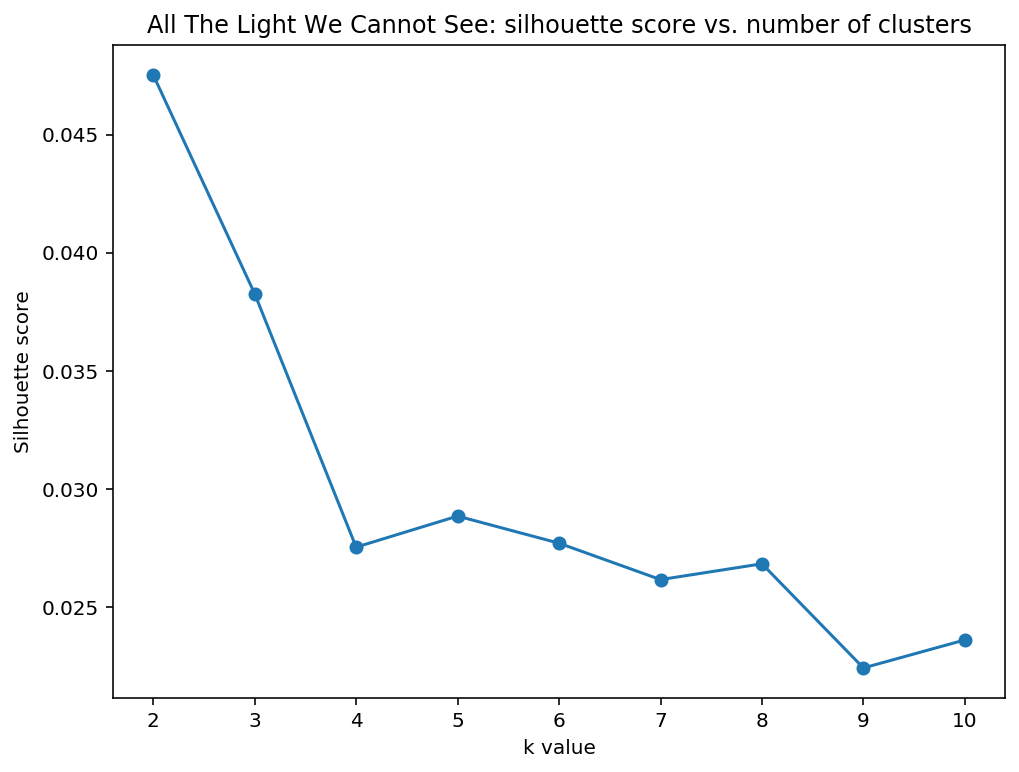

In [13]:
plt.figure()
plt.plot(ks, sil_scores, marker='o')
plt.xlabel('k value')
plt.ylabel('Silhouette score')
plt.title('All The Light We Cannot See: silhouette score vs. number of clusters')
plt.show()

This plot looks very different! 9 is nowhere near a peak anymore, and the point closest to a peak is now 5.

Let's see how much this difference actually affects our results. We'll first look at sentence clusters with k = 5, and then with k = 9.

In [14]:
# Sentence clusters for k = 5
get_clusters(atlwcs_sentences, atlwcs_sentence_vectors, k=5, n=8)

Cluster #1 sentences:

This book was honestly one of the most beautifully written books I have ever read.
Honestly this book is unlike anything I have ever read.
I guess this is why this book is definitely one of the best books I've read so far.
I don't know what to write this book is one of my favorite books ever!
I really enjoyed every minute of reading this book.
This book was quite possibly one of the most beautiful and engrossing books that I have ever read.
I thought this book was extremely well written.
This book is absolutely wonderful to read.


Cluster #2 sentences:

The story of Werner, a German boy who's life pushed him into the Hitler Youth Camps, and Mary-Laure, a French blind girl whose life is painfully interrupted by the war, was simply beautiful to read.
Beautiful and haunting story of a French girl and a German boy and how the war intimately affects their lives during WWII
This novel is about a blind French girl and a German orphan during World War II, and the way th

Again, the clusters here look pretty uniform. Thematically, we can summarize them as follows:

1. Best book
1. Plot synopsis
1. (Too) long
1. Beautifully written
1. Thematic summary

Let's see what things look like with k = 9.

In [15]:
# Sentence clusters for k = 9
get_clusters(atlwcs_sentences, atlwcs_sentence_vectors, k=9, n=8)

Cluster #1 sentences:

All The Light We Cannot See is so beautiful and heartbreaking.
To me, I feel like Doerr is talking about all the little pieces in the universe that bring a joy to someone else that we never truly realise.
As the world falls apart around them and they witness the horrors of war, they each try to be true to themselves.
As if the exquisite writing of the book wasn't enough to entice you, the story of All the Light We Cannot See is full of the pure magic of the human life.
All The Light We Cannot See is a story about life in the lead up to, and during, WWII.
All The Light We Cannot See is heart wrenching.
All The Light We Cannot See is not "just" a story of war, but is one of redemption.
It takes skill to find the light in the darkness of war, and Doerr's writing not only finds it, he leaves the reader shattered, but still happy at the end of the novel.


Cluster #2 sentences:

This book was honestly one of the most beautifully written books I have ever read.
This bo

Again, the clusters here are uniform (which is not a surprise, given the nature of USE embeddings and the number of sentences in our dataset). Thematically, we can describe them as follows:

1. Beautiful & heartbreaking
1. Best book
1. Liked it, but...
1. Great characters
1. ?
1. Plot synopsis (WWII)
1. Character synopsis (Marie-Laure)
1. Beautifully written
1. Character synopsis (Werner)

As we can see, our actual resuts are not much worse when extracting nine views than when extracting five. There's some repetition between clusters #1 and #3, cluster #4 is a bit semantically unclear, and we have more character and plot synopses than before. But this is still completely intelligible and meaningful output, and in some ways having nine views is more illustrative than having just five.

Out of curiosity, what happens when we set k even lower, to 3?

In [16]:
# Sentence clusters for k = 3
get_clusters(atlwcs_sentences, atlwcs_sentence_vectors, k=3, n=8)

Cluster #1 sentences:

Well written but I kept waiting for a huge ending but it never happened.
I liked it although it took me forever to read.
It's been a LONG time since I've read one that I enjoyed as much as this one!
The end annoyed me and made me sad at the same time.
I loved this book--right up until the end.
I liked it well enough but this one didn't quite get there, for me.
I'm starting to feel a bit more for the characters but the end was not as satisfying as I thought it would be.
I liked the story, it was just a lot going on.


Cluster #2 sentences:

This is a big book about two victims of World War II, a blind French girl and a reluctant Nazi boy, and how they get engulfed by events beyond their control and live through horrors we can barely imagine.
I thought it was a unique perspective on WWII told in the perspective a French blind girl and an orphan German boy and how their lives intersected not only by the war but by the radio.
The story of a blind French girl during W

Again, the resuts here are good and readily interpretable: we can quickly see that people think *All The Light You Can See* is well written, about World War II, and maybe a bit disappointing in the end.

In light of these preliminary results, it seems that it would be misguided to try to fix an "optimal" value of k for our model. There are pragmatic reasons for preferring a higher or lower value, depending on how many distinct views you wish to see. Rather, it might be better to incorporate k as a *interactive* parameter that can be adjusted by the user as they are interacting with algorithm.

## An alternative measure of semantic uniformity

Let's step back for a minute, as there's a weakness in the way we have been proceeding thus far. Both the inertia score and the silhouette score are metrics that measure cluster uniformity by taking into account *all* of the points that fall into that cluster. But as previously noted, we don't actually care about all of the points in each cluster, because we aren't trying to identify all of the sentences in our dataset as falling into one cluster or another. Rather, we are trying to identify particularly dense regions in our vector space, which means that we care only about the points near the centre of each of our clusters.

With this in mind, let's construct a way of measuring the semantic uniformity of just the closest points around each cluster centre. It's a bit arbitrary how many points we choose to look at; here we choose to look at 2% of the total number of points (i.e., sentences) in the dataset. The semantic uniformity of the cluster centre can then be approximated by calculating the average of the inner product of each of these points and the cluster centre. If we repeat this process for each cluster centre, we can then take the average of all these average values. This average will represent the overall semantic uniformity of our model. We'll call this the model's "density score".

In [17]:
def get_density(sentence_vectors, k_min=2, k_max=10):
    '''
    Function to get density scores for a range of k values
    '''

    # Set range of k values to loop through
    ks = range(k_min, k_max + 1)
    
    # Initialize list to store density scores
    density_scores = []
    
    # Set the number of points at the centre of each cluster to look at
    centre_points = int(len(sentence_vectors) * 0.02)

    # Loop through values of k
    for k in ks:

        # Instantiate the model
        kmeans_model = KMeans(n_clusters=k, random_state=42)

        # Fit the model
        kmeans_model.fit(sentence_vectors)

        # Initialize list to store mean inner product value
        mean_ips = []

        # Loop through number of clusters
        for i in range(k):

            # Define cluster centre
            centre = kmeans_model.cluster_centers_[i]

            # Calculate inner product of cluster centre and sentence vectors
            ips = np.inner(centre, sentence_vectors)

            # Find the sentences with the highest inner products
            top_ips = pd.Series(ips).nlargest(centre_points)

            # Append the mean inner product value to master list
            mean_ips.append(top_ips.mean())

        # Append the mean of the mean inner product values to density score list
        density_scores.append(np.mean(mean_ips))
    
    return density_scores, ks

In [18]:
# Calculate density scores
density_scores, ks = get_density(atlwcs_sentence_vectors)

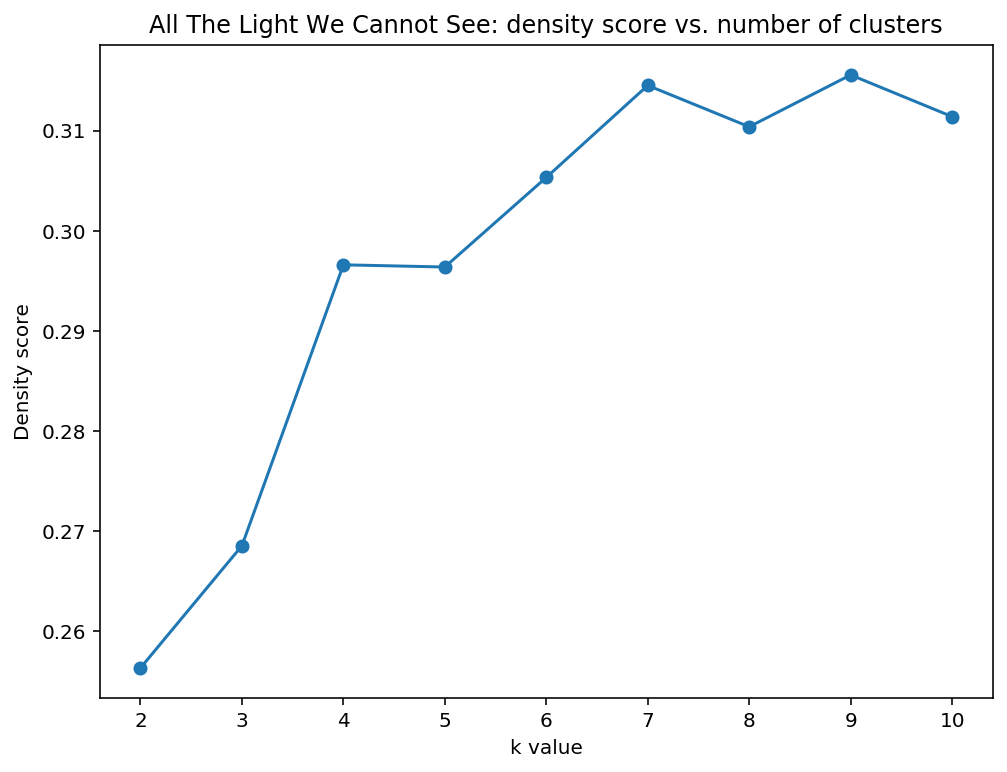

In [20]:
# Plot density scores vs. k
plt.figure()
plt.plot(ks, density_scores, marker='o')
plt.xlabel('k value')
plt.ylabel('Density score')
plt.title('All The Light We Cannot See: density score vs. number of clusters')
plt.show()

This is interesting! The highest density scores are at k = 7 and k = 9, much different from the k value of 5 we derived from the silhouette score plot above. This suggests that a higher value of k might actually be better from the perspective of our particular use case.

Let's see how these results compare with the density scores for *Gone Girl*.

In [21]:
# Calculate density scores
density_scores, ks = get_density(gg_sentence_vectors)

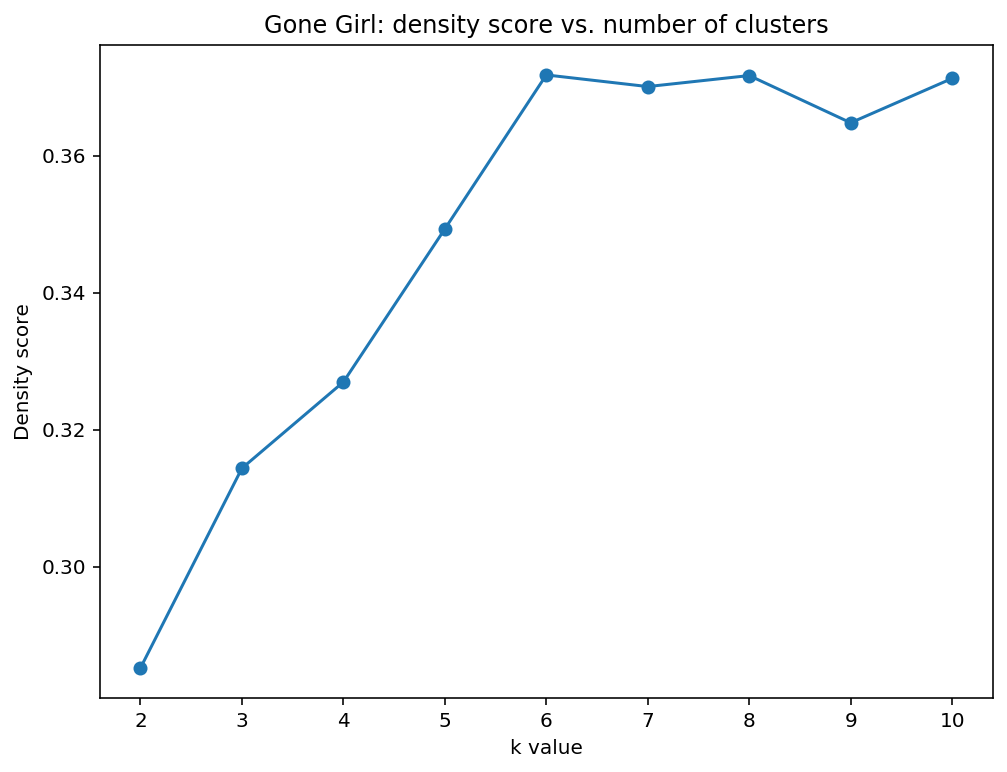

In [22]:
# Plot density scores vs. k
plt.figure()
plt.plot(ks, density_scores, marker='o')
plt.xlabel('k value')
plt.ylabel('Density score')
plt.title('Gone Girl: density score vs. number of clusters')
plt.show()

Here we can see a similar pattern as above: the model's density score is highest at k = 6 or k = 8.

Might this be indicative of a broader pattern, across all books? Let's check a few more to find out. Here we now choose three books with a variable number of sentences in their set of reviews, some higher than our previous two books and some lower.

In [23]:
# Calculate density scores for three books
sentences, sentence_vectors = load_sentences('data/11870085_the_fault_in_our_stars.csv')
tfios_num_sents = len(sentences)
tfios_density_scores, ks = get_density(sentence_vectors)

sentences, sentence_vectors = load_sentences('data/17333223_the_goldfinch.csv')
gf_num_sents = len(sentences)
gf_density_scores, ks = get_density(sentence_vectors)

sentences, sentence_vectors = load_sentences('data/4214_life_of_pi.csv')
lop_num_sents = len(sentences)
lop_density_scores, ks = get_density(sentence_vectors)

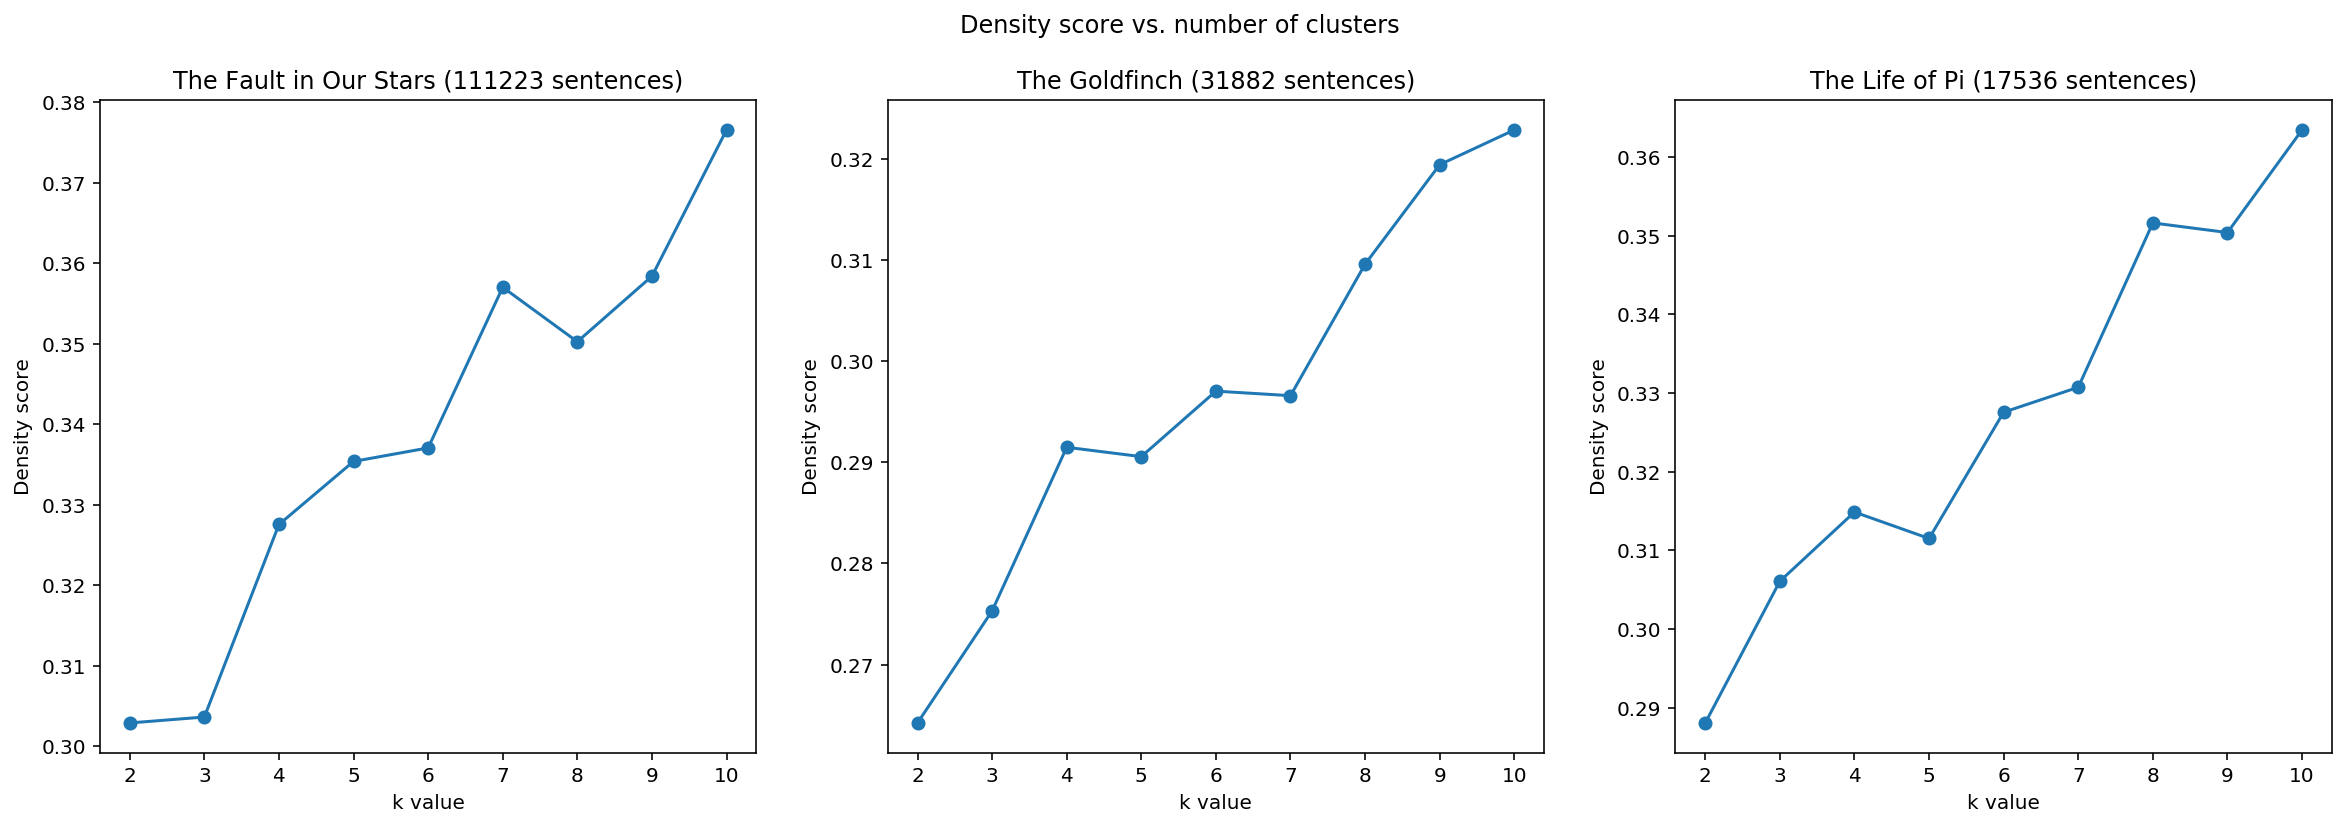

In [24]:
# Plot density scores vs. k
plt.figure(figsize=(20, 6))

plt.subplot(131)
plt.plot(ks, tfios_density_scores, marker='o')
plt.xlabel('k value')
plt.ylabel('Density score')
plt.title(f'The Fault in Our Stars ({tfios_num_sents} sentences)')

plt.subplot(132)
plt.plot(ks, gf_density_scores, marker='o')
plt.xlabel('k value')
plt.ylabel('Density score')
plt.title(f'The Goldfinch ({gf_num_sents} sentences)')

plt.subplot(133)
plt.plot(ks, lop_density_scores, marker='o')
plt.xlabel('k value')
plt.ylabel('Density score')
plt.title(f'The Life of Pi ({lop_num_sents} sentences)')

plt.suptitle('Density score vs. number of clusters')

plt.show()

Here we again see similar trends as before: the semantic uniformity of the cluster centres seems to increase as the number of clusters increases, between 2 and 10.

These results suggest that a better default value of k for our model would be closer to 8 or 9 rather than 3 or 4. However, these results do not entail that 8 or 9 is the *optimal* value of k. As noted above, it is wrong to think of there being just one "optimal" value of k. Different values of k are better suited for different purposes. Thus we still maintain that k should be an interactive parameter that the user can freely adjust.

That being said, the density score might be helpfully incorporated into our model's output, as an indicator of the semantic uniformity of each identified cluster. This would provide us a way of quickly indicating to the user how uniform each individual cluster is in comparison to the others. Here's an example of what that could look like.

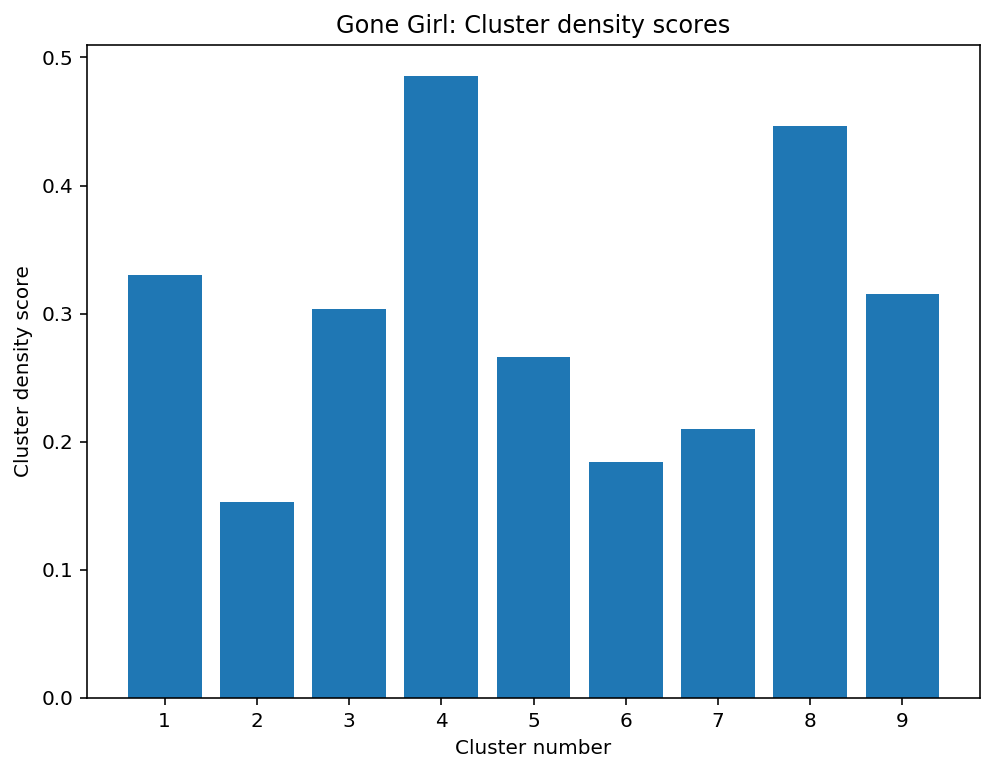

In [25]:
# Calculate and plot cluster density scores for Gone Girl with k = 9

k = 9
kmeans_model = KMeans(n_clusters=k, random_state=24)
kmeans_model.fit(gg_sentence_vectors);

centre_points = int(len(sentence_vectors) * 0.02)
mean_ips = []

for i in range(k):
    centre = kmeans_model.cluster_centers_[i]
    ips = np.inner(centre, sentence_vectors)
    top_ips = pd.Series(ips).nlargest(centre_points)
    mean_ips.append(top_ips.mean())

plt.figure()
plt.bar(range(1,k+1), mean_ips)
plt.xticks(range(1,k+1))
plt.xlabel('Cluster number')
plt.ylabel('Cluster density score')
plt.title('Gone Girl: Cluster density scores')
plt.show()

If we compare these results to the sentence output we generated earlier in this notebook, these results seem to make sense. Cluster #2 does indeed show a lower degree of semantic uniformity, whereas Cluster #4 shows a higher degree.

## Endnote: Detecting semantic density with DBSCAN

There is one other method by which we could try to detect semantic density in our dataset of sentences. It is actually a different clustering model entirely: DBSCAN. This might actually seem like a better approach for our situation, since DBSCAN classifies data points into clusters by seeing if they fall into clumps with other data points, and classifies all data points that don't fall into clumps as outliers. Thus, in theory, we might be able to use DBSCAN to automatically ignore the outlier sentences in our dataset and only identify the dense clumps of semantically similar sentences.

Though we not entirely anticipate this, we were able to achieve some non-trivial results with this method. Let's see them.

In [26]:
from sklearn.cluster import DBSCAN

# Instantiate the model (parameters are chosen somewhat at random)
db_model = DBSCAN(eps=0.75, min_samples=15)

# Fit the model
db_model.fit(gg_sentence_vectors);

In [27]:
# Create a series of each data point's label
sentence_labels = pd.Series(db_model.labels_)

# Get total counts of each label
sentence_labels.value_counts()

-1    33824
 0     7120
 2      784
 6       38
 4       33
 1       27
 7       17
 5       15
 3       15
dtype: int64

As we can see here, our DBSCAN model has classified the vast majority of sentences as outliers (these are the 33,824 points that have been labelled as -1). Beyond that, the model has identified 8 other clusters. Unfortunately, most of these clusters are very low in population (with between only 15 and 38 sentences), and one is very high (with over 7,000).

Let us take a closer look at these results and see what sentence clusters the model has identified.

In [29]:
# Loop through each cluster
for k in range(8):
    
    # Get the indices of all rows with that cluster's label
    indices = sentence_labels[sentence_labels == k].index
    
    # Get the sentences at each of those indices
    cluster_sentences = gg_sentences[indices]
    
    # Pick five sentences at random from set of sentences
    sample_sentences = list(cluster_sentences.sample(8, random_state=24))

    print(f'Cluster #{k} sentences:\n')
    print(*sample_sentences, sep='\n')
    print('\n')

Cluster #0 sentences:

I am fascinated and want to read more of Gillian Flynn's books.
I hated the characters, but I think that was the point!
I will go and try to read a different book from this author as I did like the writing style.
this book was hard for me to get into, but about a third of the way in I could not put it down.
Wonderful twists and turns in this dark thriller.
Ending was fairly disappointing though which was sad.
Many people are complaining about the ending and I agree.
Holy crap that was one of the craziest most twisted books I have ever read and I have read some pretty twisted stuff!!!


Cluster #1 sentences:

After losing their New York positions, they head back to Nick's hometown in Missouri to care for his dying mother and father.
Though they courted in New York, both lost their jobs and family needs motivated them to move to Nick's Missouri hometown to attend to his ailing parents.
Nick and Amy began as the perfect couple, but things changed along the way with 

If we scroll through these results, we can see that the model does a decent enough job of clustering together semantically sentences (with the apparent exception of Cluster #0). However, its clusters appear less meaningful. Rather, the model is simply clustering together near identical sentences (or, as in the case of Cluster #5, actually identical quotes from the book). The results we achieved via k-means clustering were much more revealing and seemingly representative of the set of reviews. Because of this (and because DBSCAN is a much more computationally expensive operation than k-means clustering), we will not pursue DBSCAN any further as a model.